# Automatic Number Plate Recognition in Shogun

***Automatic Number Plate Recognition (ANPR)***, is a surveillance method that uses ***Optical Character Recognition (OCR)*** and other methods such as segmentations and
detection to read vehicle registration plates.

The best results in an **ANPR** system can be obtained with an infrared (IR) camera,
because the segmentation steps for detection and OCR segmentation are easy, clean,
and minimize errors. Sadly, we do not use IR photographs here. That is we are going to try and get same results with regular photographs only!

Each country has different license plate sizes and specifications; it is useful to know
these specifications in order to get the best results and reduce errors. The algorithms
used here are intended to explain the basics of **ANPR** and the specifications
for license plates.

In [1]:

from IPython.display import Image


The whole algorithmic approach is structured as following:
1. **Plate Detection**
2. **Segmentation**
3. **Classification**
4. **Plate Recognition**
5. **OCR Segmentation**
6. **Feature Extraction**
7. **OCR Classification**

We will go through each of these steps one by one.

## 1. Plate Detection

First load a car image. It's better to see what we are dealing with

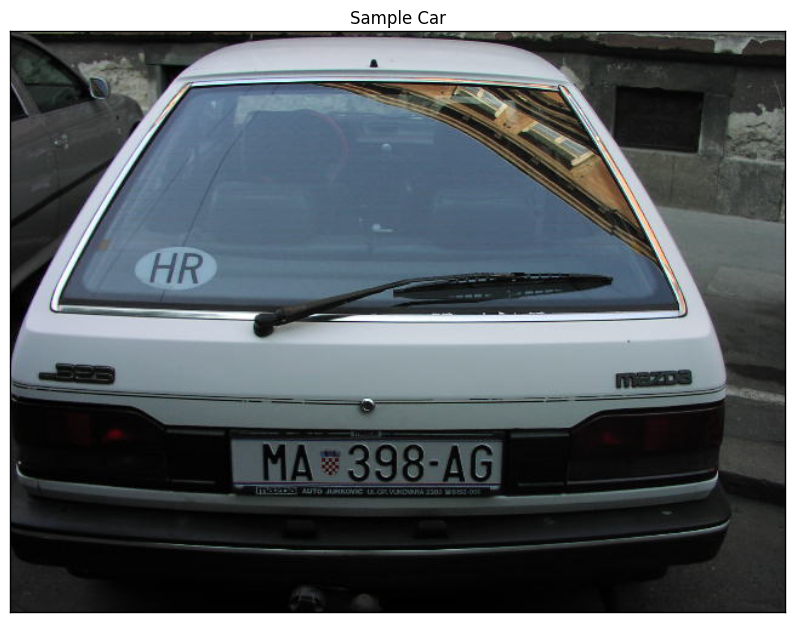

In [2]:
#Use the following function when reading an image through OpenCV and displaying through plt.
def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    
#import Opencv library
try:
    import cv2
except ImportError:
    print ("You must have OpenCV installed")
    exit(1)

#checking the OpenCV version
try:
    v=cv2.__version__
    assert (tuple(map(int,v.split(".")))>(2,4,3))
except (AssertionError, ValueError):
    print ("Install newer version of OpenCV than 2.4.3, i.e from 2.4.4")
    exit(1)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

plt.rcParams['figure.figsize'] = 10, 10 

# Actual Code starts here
plt.title('Sample Car')
image_path="C:/Users/Manoj.N.K/gitamintern/anprproject/images/23.jpg"
carsample=cv2.imread(image_path)
showfig(carsample,None)

In this step we have to detect all the plates in the current camera frame. Two broad categories in which they can be defined are:

1. ** Segmentation**
2. **Classification**

### Segmentation

Segmentation is the process of dividing an image into multiple segments. This
process is to simplify the image for analysis and make feature extraction easier.

One important feature that we can exploit from Number plates are the high number of vertical edges. But before that, we need to do some handy preprocessing of the current image namely:

1. **grayscale conversion** : color won't help us in this task
2. **Remove Noise** : A 5x5 Gaussian blur to remove unwanted vertical edges

To find the vertical edges, we will use a Sobel filter and find its first horizontal derivative.

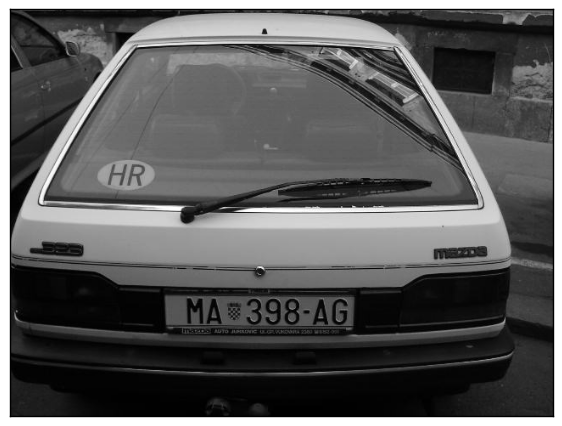

In [3]:
plt.rcParams['figure.figsize'] = 7,7

# convert into grayscale
gray_carsample=cv2.cvtColor(carsample, cv2.COLOR_BGR2GRAY)
showfig(gray_carsample, plt.get_cmap('gray'))

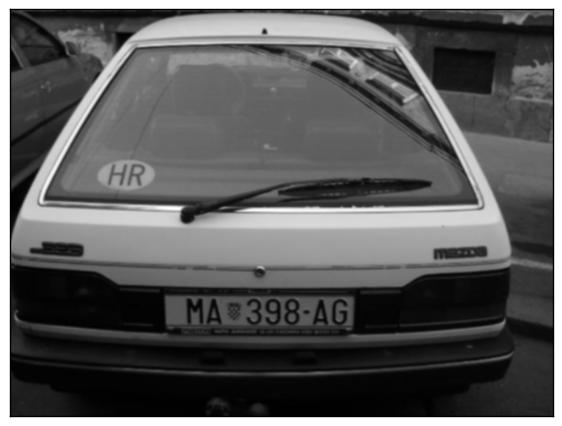

In [4]:
# blur the image
blur=cv2.GaussianBlur(gray_carsample,(5,5),0)
showfig(blur, plt.get_cmap('gray'))

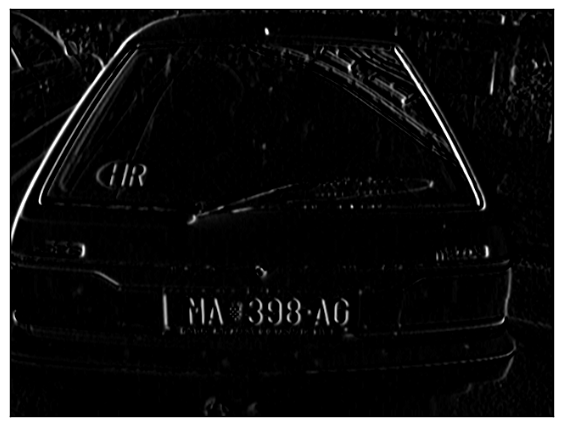

In [5]:
# find the sobel gradient. use the kernel size to be 3
sobelx=cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=3)
showfig(sobelx, plt.get_cmap('gray'))

After a Sobel Filter, we apply a threshold filter to obtain a binary image with a threshold value obtained through Otsu's Method.Otsu's algorithm needs an 8-bit input
image and Otsu's method automatically determines the optimal threshold value:

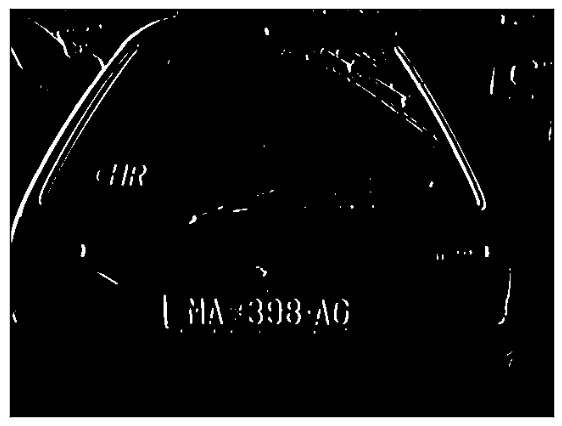

In [6]:
#Otsu thresholding
_,th2=cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
showfig(th2, plt.get_cmap('gray'))

By applying a close morphological operation, we can remove blank spaces between
each vertical edge line, and connect all regions that have a high number of edges. In
this step we have the possible regions that can contain plates.

First we define our structural element to use in our morphological operation. We will
use the **getStructuringElement()** function to define a structural rectangular element
with a 23 x 2 dimension size in our case; this may be different in other image sizes and use this structural element in a close morphological operation using the **morphologyEx()** function:

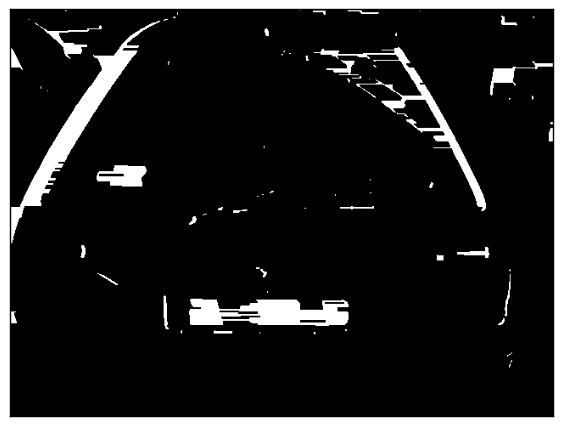

In [7]:
#Morphological Closing
se=cv2.getStructuringElement(cv2.MORPH_RECT,(23,2))
closing=cv2.morphologyEx(th2, cv2.MORPH_CLOSE, se)
showfig(closing, plt.get_cmap('gray'))

After all these preprocessing steps, we have regions in the image that have the possibility of containing license plates. 

This calls for the use of **findContours()** function. This function retrieves the contours of a binary image. 

In [8]:
_,contours,_=cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Lets visualize all the detected contours approximated to there  rectangular BoundingBoxes. OpenCV has **minAreaRect()** function exactly for this task. We use **BoxPoints()** function to extract all the four co-ordinates of the rectangle which is then used to draw the boundingbox.

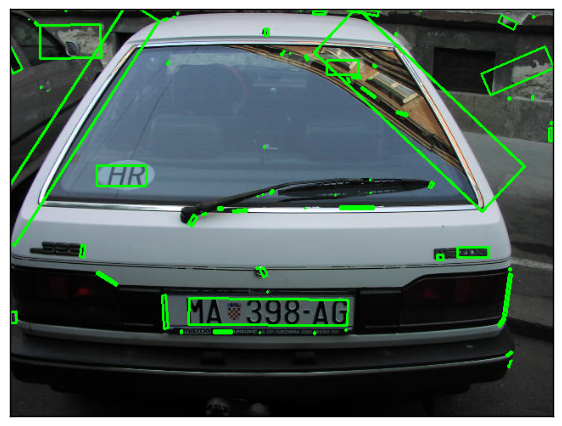

In [9]:
for cnt in contours:
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    cv2.drawContours(carsample, [box], 0, (0,255,0),2)
showfig(carsample, None)

There are too many false positives! Well, Lets try to remove the outliers by validating against their area and aspect ratio. 

* A normal number plate should have an aspect ratio of atleast more than 3.
* Outstanding area should be around 8000. Lets make a rough range(maybe there's a exception) of area between 3000 to 16000 pixels. We don't want the actual number plate to disappear!

To carry out this task we define a separate function.

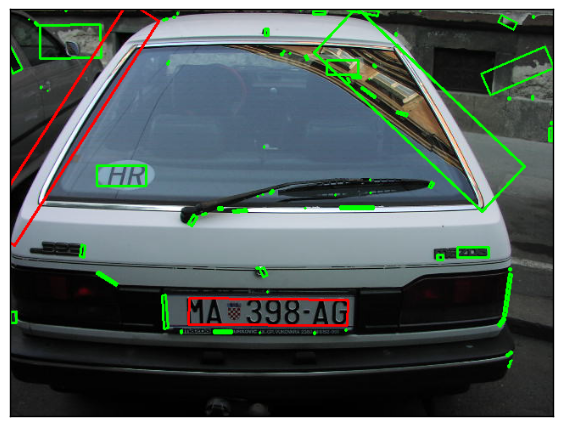

In [10]:
#validate a contour. We validate by estimating a rough area and aspect ratio check.
def validate(cnt):    
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>3) & (height>width)) | ((width/height>3) & (width>height))):
            if((height*width<16000) & (height*width>3000)): 
                output=True
    return output

#Lets draw validated contours with red.
for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt)  
        box=cv2.boxPoints(rect) 
        box=np.int0(box)  
        cv2.drawContours(carsample, [box], 0, (0,0,255),2)
showfig(carsample, None)

This has improved the results but we want to do still better.
But mind it. We are not going to get more strict and remove it.

 License Plates generally have a white background. That means we can use a **flood fill** algorithm.

**flood fill** is very similar to the old Fill color that you might have used in MS Paint or other drawing programs! It tries to spread your choosen color from the point of origin to every direction untill it faces a tangible boundary preventing it to go any further.

For applying this algorithm, we need to have the origin (also known as **seeds**). Since we have no idea how to choose a specific **seed** within these validated rectangles, we will randomize it and hope that atleast one of them suceeds in exploiting the white background of a actual License Plate and **floodfills** a considerable chunk of it

In [11]:
# defining a function doing this will come handy.
def generate_seeds(centre, width, height):
    minsize=int(min(width, height))
    seed=[None]*10
    for i in range(10):
        random_integer1=np.random.randint(1000)
        random_integer2=np.random.randint(1000)
        seed[i]=(centre[0]+random_integer1%int(minsize/2)-int(minsize/2),centre[1]+random_integer2%int(minsize/2)-int(minsize/2))
    return seed

We want to select the white region and we need several seeds to touch at least one
white pixel. Now for each seed that we get from the previous function, we use a **floodFill()** function to draw a new mask image to store the new closest cropping region

The **floodFill()** function fills a connected component with color into a mask image starting from a seed point, and sets maximal lower and upper brightness/color difference between the pixel to fill.

The required parameters that are needed:
* **newval**: the new color that we want to put in
* **lodiff & updiff**: the maximal lower and maximal upper brightness/color difference
* The **flag** parameter is a combination of **Lower bits** and **Upper bits**

Here:
* **Lower bits** contain the connectivity value, It determines which neighbours of a pixel are considered.
* **Upper bits** is here a combination of **CV_FLOODFILL_FIXED_RANGE**  and **CV_FLOODFILL_MASK_ONLY** 
    
Here:
* **CV_FLOODFILL_FIXED_RANGE** sets the difference between the current pixel and the seed pixel.
* **CV_FLOODFILL_MASK_ONLY** will only fill the image and not change the image itself.

In [12]:
#masks are nothing but those floodfilled images per seed.
CV_FLOODFILL_FIXED_RANGE =(1 << 16)
CV_FLOODFILL_MASK_ONLY   =(1 << 17)

def generate_mask(image, seed_point):
    h=carsample.shape[0]
    w=carsample.shape[1]
    #OpenCV wants its mask to be exactly two pixels greater than the source image.
    mask=np.zeros((h+2, w+2), np.uint8)
    #We choose a color difference of (50,50,50). Thats a guess from my side.
    lodiff=50
    updiff=50
    connectivity=4
    newmaskval=255
    flags=connectivity+(newmaskval<<8)+CV_FLOODFILL_FIXED_RANGE+CV_FLOODFILL_MASK_ONLY
    _=cv2.floodFill(image, mask, seed_point, (255, 0, 0),
                    (lodiff, lodiff, lodiff), (updiff, updiff, updiff), flags)
    return mask


In [13]:
# we will need a fresh copy of the image so as to draw masks.
carsample_mask=cv2.imread(image_path)

# for viewing the different masks later
mask_list=[]

for cnt in contours:
    if validate(cnt):
        rect=cv2.minAreaRect(cnt) 
        centre=(int(rect[0][0]), int(rect[0][1]))
        width=rect[1][0]
        height=rect[1][1]
        seeds=generate_seeds(centre, width, height)
        
        #now for each seed, we generate a mask
        for seed in seeds:
            # plot a tiny circle at the present seed.
            cv2.circle(carsample, seed, 1, (0,0,255), -1)
            # generate mask corresponding to the current seed.
            mask=generate_mask(carsample_mask, seed)
            mask_list.append(mask)   

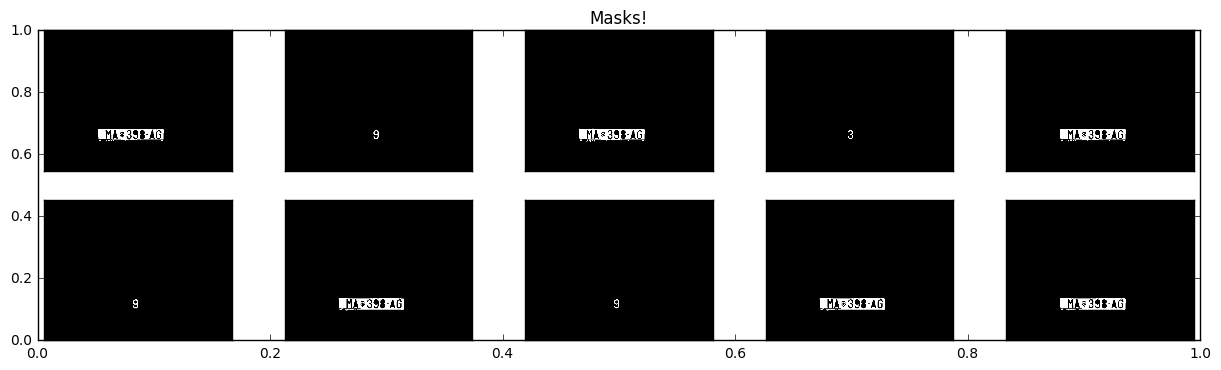

In [14]:
#We plot 1st ten masks here
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
plt.title('Masks!')
for mask_no in range(10):
    fig.add_subplot(2, 5, mask_no+1)
    showfig(mask_list[mask_no], plt.get_cmap('gray'))

We will use our area and aspect ratio checks again on the approximated bounding boxes of the above masks!

In [15]:
validated_masklist=[]
for mask in mask_list:
    contour=np.argwhere(mask.transpose()==255)
    if validate(contour):
        validated_masklist.append(mask)

In [16]:
try:
    assert (len(validated_masklist)!=0)
except AssertionError:
    print ("No valid masks could be generated")
    exit(1)

Most probable masks are now here. But there may be those cases where almost same masks are repeated. This is possible as the seeds were random and there can always be more than 1 seed producing the same mask.

In [17]:
# We check for repetation of masks here.
#from scipy import sum as
#import scipy.sum as scipy_sum
# This function quantifies the difference between two images in terms of RMS.
def rmsdiff(im1, im2):
    diff=im1-im2
    output=False
    if np.sum(abs(diff))/float(min(np.sum(im1), np.sum(im2)))<0.01:
        output=True
    return output

# final masklist will be the final list of masks we will be working on.
final_masklist=[]
index=[]
for i in range(len(validated_masklist)-1):
    for j in range(i+1, len(validated_masklist)):
        if rmsdiff(validated_masklist[i], validated_masklist[j]):
            index.append(j)
for mask_no in list(set(range(len(validated_masklist)))-set(index)):
    final_masklist.append(validated_masklist[mask_no])

Now that the segmentation process is finished and we have valid regions, we can remove any possible rotation, crop the image region, resize the image, and equalize the light of cropped image regions.

In [18]:
cropped_images=[]
for mask in final_masklist:
    contour=np.argwhere(mask.transpose()==255)
    rect=cv2.minAreaRect(contour)
    width=int(rect[1][0])
    height=int(rect[1][1])
    centre=(int(rect[0][0]), int(rect[0][1]))
    box=cv2.boxPoints(rect) 
    box=np.int0(box)
    #check for 90 degrees rotation
    if ((width/float(height))>1):
        # crop a particular rectangle from the source image
        cropped_image=cv2.getRectSubPix(carsample_mask, (width, height), centre)
    else:
        # crop a particular rectangle from the source image
        cropped_image=cv2.getRectSubPix(carsample_mask, (height, width), centre)

    # convert into grayscale
    cropped_image=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    # equalize the histogram
    cropped_image=cv2.equalizeHist(cropped_image)
    # resize to 260 cols and 63 rows. (Just something I have set as standard here)
    cropped_image=cv2.resize(cropped_image, (260, 63))
    cropped_images.append(cropped_image)




Lets see these cropped regions.

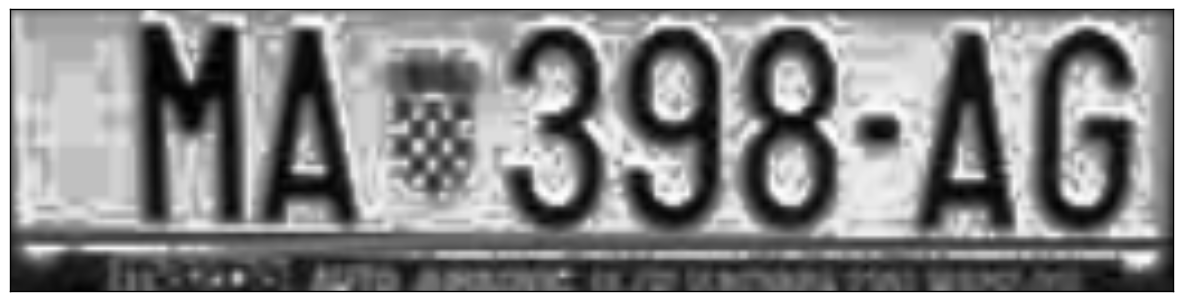

In [19]:
from past.builtins import xrange
_=plt.subplots_adjust(hspace=0.000)
number_of_subplots=len(cropped_images)
for i,v in enumerate(xrange(number_of_subplots)):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,1,v)
    showfig(cropped_images[i], plt.get_cmap('gray'))

### Classification

After we preprocess and segment all possible parts of an image, we need now to decide if each segment is or is not a license plate. To do this, we will use Shogun's Support Vector Machines Framework.

Basically we will be training a 2 class LibSVM. One class for positive training image of License Plate and other class for the negatives.

I cropped almost 198 positive license plates images from the before mentioned database. Along with it, a set of 79 negative images are also cropped. These are already histogram equalized and reshaped into a size of 63 rows and 260 columns.(I have choosen this as the standard here)  

Lets see a part of it.

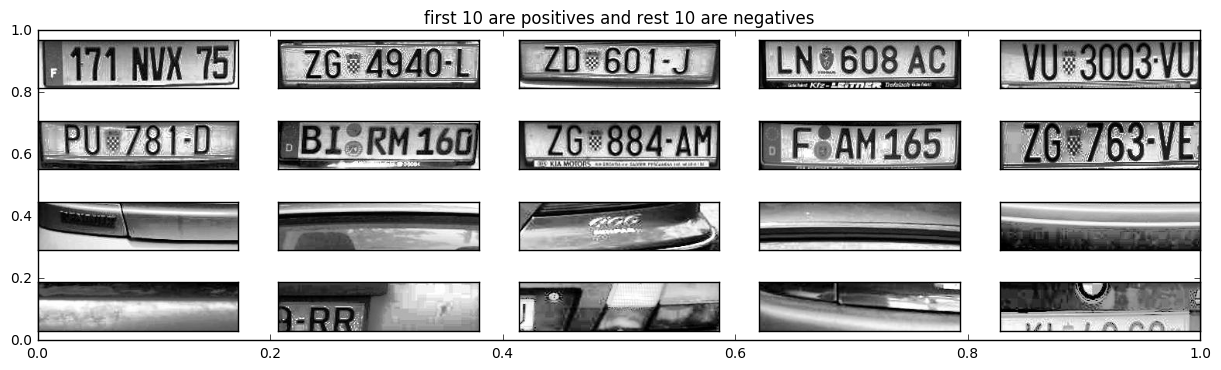

In [20]:
import os
def get_imlist(path):
    return [[os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]]


training_sample=[]  
#We plot 1st ten positive and negative license plates here
path_train='C:/Users/Manoj.N.K/gitamintern/anprproject/svm_train/positive/'
filenames=np.array(get_imlist(path_train))
for i in range(10):
    temp=cv2.imread(filenames[0][i])
    temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    training_sample.append(temp)
path_train='C:/Users/Manoj.N.K/gitamintern/anprproject/svm_train/negative/'
filenames=np.array(get_imlist(path_train))
for i in range(10):
    temp=cv2.imread(filenames[0][i])
    temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    training_sample.append(temp)
    
plt.rcParams['figure.figsize'] = 15,4
fig = plt.figure()
plt.title('first 10 are positives and rest 10 are negatives')
for image_no in range(20):
    fig.add_subplot(4, 5, image_no+1)
    showfig(training_sample[image_no], plt.get_cmap('gray'))

Below is function **get_svm()**. It will initialize a 2 class LibSVM on the training and testing dataset.

In [21]:
from shogun import *
def get_vstacked_data(path):
    filenames=np.array(get_imlist(path))
    #read the image
    #convert the image into grayscale.
    #change its data-type to double.
    #flatten it
    vmat=[]
    for i in range(filenames[0].shape[0]):
        temp=cv2.imread(filenames[0][i])
        temp=cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
        temp=cv2.equalizeHist(temp)
        temp=np.array(temp, dtype='double')
        temp=temp.flatten()
        vmat.append(temp)
    vmat=np.vstack(vmat)
    return vmat

def get_svm():
    
    #set path for positive training images
    path_train='C:/Users/Manoj.N.K/gitamintern/anprproject/svm_train/positive/'
    pos_trainmat=get_vstacked_data(path_train)
    
    #set path for negative training images
    path_train='C:/Users/Manoj.N.K/gitamintern/anprproject/svm_train/negative/'
    neg_trainmat=get_vstacked_data(path_train)

    #form the observation matrix
    obs_matrix=np.vstack([pos_trainmat, neg_trainmat])
    
    #shogun works in a way in which columns are samples and rows are features.
    #Hence we need to transpose the observation matrix
    obs_matrix=obs_matrix.T

    #get the labels. Positive training images are marked with +1 and negative with -1
    labels=np.ones(obs_matrix.shape[1])
    labels[pos_trainmat.shape[0]:obs_matrix.shape[1]]*=-1
    
    #convert the observation matrix and the labels into Shogun RealFeatures and BinaryLabels structures resp. .
    sg_features=RealFeatures(obs_matrix)
    sg_labels=BinaryLabels(labels)

    #Initialise a basic LibSVM in Shogun.
    width=2
    #kernel=GaussianKernel(sg_features, sg_features, width)
    kernel=LinearKernel(sg_features, sg_features)
    C=1.0
    svm=LibSVM(C, kernel, sg_labels)
    _=svm.train()
    
    _=svm.apply(sg_features)
    return svm

Lets run the above function to train this SVM.

In [22]:
svm=get_svm()

Our classifier is ready to predict a possible cropped image using the **apply()**
function of our SVM class; this function returns the class identifier i. In our case,
we label a plate class with 1 and no plate class with -1. Then for each detected region
that can be a plate, we use SVM to classify it as a plate or no plate, and save only
the correct responses.

In [23]:
segmentation_output=[]
for cropped_image in cropped_images:
    cropped_image=np.array([np.double(cropped_image.flatten())])
    sg_cropped_image=RealFeatures(cropped_image.T)
    output=svm.apply(sg_cropped_image)
    print (output.get_labels()[0])
    # if it passes we append it
    if(output.get_labels()[0]==1):
        segmentation_output.append(cropped_image[0])

1.0


In [24]:
try:
    assert (len(segmentation_output)!=0)
except AssertionError:
    print ("SVM couldn't find a single License Plate here. Restart to crosscheck!The current framework is closing")
    exit(1)

## Plate recognition

The second step in license plate recognition aims to retrieve the characters of the license plate with optical character recognition. For each detected plate, we proceed to segment the plate for each character, and use an Artificial Neural Network (ANN) machine-learning algorithm to recognize the character

The dataset that we are using for training this ANN are generated by the cropped images of each letter from the License Plate Database. We can use a standard ocr data set also.

Unlike the plate detection feature-extraction step that is used in SVM, we don't use all of the image pixels; we will apply more common features used in optical character recognition containing horizontal and vertical accumulation histograms and a low-resolution image sample(10 rows and 5 cols here).

For each character, we count the number of pixels in a row or column with a non-zero value and use them as features. Thus the three features that we intend to use here are:
1. **horizontal histogram**
2. **vertical histogram**
3. **10x5 downsampled character image**


### Feature Extraction

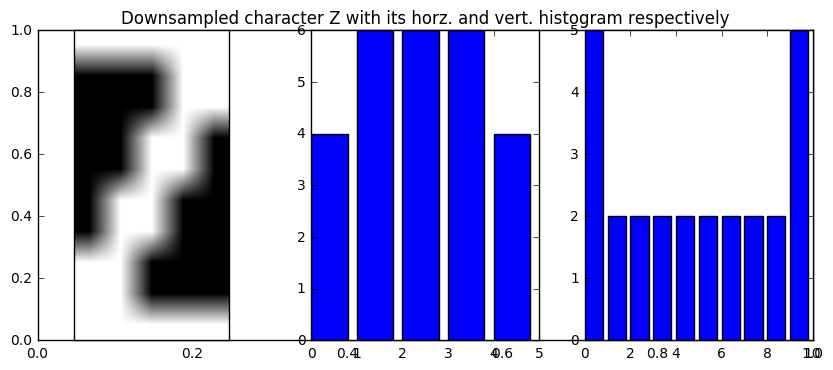

In [25]:
im=cv2.imread("C:/Users/Manoj.N.K/Desktop/data/shogun-data-master/ANPR/ann/Z/12.jpg")
im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im=cv2.resize(im, (5,10), interpolation=cv2.INTER_AREA)
_,im=cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)

horz_hist=np.sum(im==255, axis=0)
vert_hist=np.sum(im==255, axis=1)
plt.rcParams['figure.figsize'] = 10,4
fig = plt.figure()
plt.title('Downsampled character Z with its horz. and vert. histogram respectively')
fig.add_subplot(131)
showfig(im, plt.get_cmap('gray'))
fig.add_subplot(132)
plt.bar(range(0,5), horz_hist)
fig.add_subplot(133)
_=plt.bar(range(0,10), vert_hist)


### OCR Segmentation

But first we need to remove the bad bounding boxes that our **findContour()** may give us. It is very similar to the one we did previously except that here we have a different aspect ratio and area to be checked. We define a function for that.

In [26]:
def validate_ann(cnt):
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box) 
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>1.12) & (height>width)) | ((width/height>1.12) & (width>height))):
            if((height*width<1700) & (height*width>100)):
                if((max(width, height)<64) & (max(width, height)>35)):
                    output=True
    return output 

Form ANN with one hidden layer. Few things to be kept in mind are:

* **number of classes**=32
* **number of features per sample image**=5(horz. hist) + 10(vert. hist)+ 10x5(flatten form of the downsampled image) i.e 65

### OCR Classification

In [27]:
values=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','J','K','L','M','N','P','R','S','T','U','V','W','X','Z']
keys=range(32)
data_map=dict(zip(keys, values))

def get_ann(data_map):
    feature_mat=[]    
    label_mat=[]
    for keys in data_map:
        path_train="C:/Users/Manoj.N.K/Desktop/data/shogun-data-master/ANPR/ann/%s"%data_map[keys]
        filenames=get_imlist(path_train)
        perfeature_mat=[]
        perlabel_mat=[]
        
        for image in filenames[0]:
            raw_image=cv2.imread(image)
            raw_image=cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
            
            #resize the image into 5 cols(width) and 10 rows(height)
            raw_image=cv2.resize(raw_image,(5, 10), interpolation=cv2.INTER_AREA)
            #Do a hard thresholding.
            _,th2=cv2.threshold(raw_image, 70, 255, cv2.THRESH_BINARY)
            
            #generate features
            horz_hist=np.sum(th2==255, axis=0)
            vert_hist=np.sum(th2==255, axis=1)
            sample=th2.flatten()
            
            #concatenate these features together
            feature=np.concatenate([horz_hist, vert_hist, sample])
            
            # append these features together along with their respective labels
            perfeature_mat.append(feature)
            perlabel_mat.append(keys)
            
        feature_mat.append(perfeature_mat)
        label_mat.append(perlabel_mat)
    
    # These are the final product.
    bigfeature_mat=np.vstack(feature_mat)
    biglabel_mat=np.hstack(label_mat)
    
    # As usual. We need to convert them into double type for Shogun.
    bigfeature_mat=np.array(bigfeature_mat, dtype='double')
    biglabel_mat=np.array(biglabel_mat, dtype='double')
   
    #shogun works in a way in which columns are samples and rows are features.
    #Hence we need to transpose the observation matrix
    obs_matrix=bigfeature_mat.T

    #convert the observation matrix and the labels into Shogun RealFeatures and MulticlassLabels structures resp. .
    sg_features=RealFeatures(obs_matrix)
    sg_labels=MulticlassLabels(biglabel_mat)
    
    #initialize a simple ANN in Shogun with one hidden layer.
    layers=DynamicObjectArray()
    layers.append_element(NeuralInputLayer(65))
    layers.append_element(NeuralLogisticLayer(65))
    layers.append_element(NeuralSoftmaxLayer(32))
    net=NeuralNetwork(layers)
    net.quick_connect()
    net.initialize_neural_network()

    net.io.set_loglevel(MSG_INFO)
    net.l1_coefficient=3e-4
    net.epsilon = 1e-6
    net.max_num_epochs = 600

    net.set_labels(sg_labels)
    net.train(sg_features) 
    return net

Train the ANN.

In [28]:
net=get_ann(data_map)

In [29]:
from platform import python_version

print(python_version())

3.5.2


In [30]:
from shogun import BinaryLabels, RealFeatures, Task, TaskGroup

For each output of the **findContours()** function, we validate it with the aspect ratio checks and apply ANN over it.

['M', 'A', '3', '9', '8', 'A', 'G']


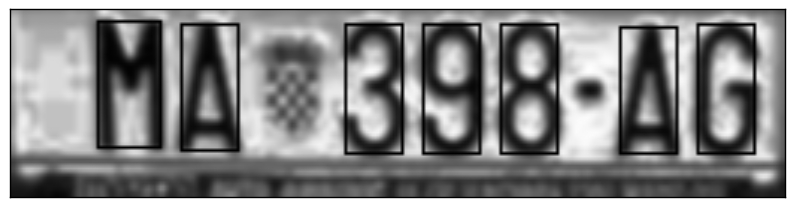

In [31]:
for svm_output in segmentation_output:
    car_number=[]
    x_distance=[]
    working_image=np.resize(np.uint8(svm_output),(63,260))
    #we follow same preprocessing routines
    working_image=cv2.equalizeHist(working_image)
    working_image=cv2.GaussianBlur(working_image,(5,5),0)
    _,th2=cv2.threshold(working_image, 75, 255, cv2.THRESH_BINARY_INV)
    contours=np.copy(th2)
    crop_copy=np.copy(th2)
    _,contours,_=cv2.findContours(contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    count=-1
    for cnt in contours:
        count=count+1
        if (validate_ann(cnt)):
            rect=cv2.minAreaRect(cnt)
            box=cv2.boxPoints(rect)
            box=np.int0(box)
            cv2.drawContours(working_image, [box], 0, (0, 255, 0),1)
            centre=rect[0]
            cropped=cv2.getRectSubPix(crop_copy,(int(min(rect[1])), int(max(rect[1]))) , centre)
            cropped_resize=cv2.resize(cropped, (5,10), interpolation=cv2.INTER_AREA)
            _, th2=cv2.threshold(cropped_resize, 70, 255, cv2.THRESH_BINARY)
    
            #generate the respective features
            horz_hist=np.sum(th2==255, axis=0)
            vert_hist=np.sum(th2==255, axis=1)
            sample=th2.flatten()
            
            feature_set=np.concatenate([horz_hist, vert_hist, sample])
            feature_set=np.array([np.double(feature_set)])
            feature_set=feature_set.T
            
            testfeature=RealFeatures(feature_set)
            output=net.apply_multiclass(testfeature)
            data_alpha=data_map[output.get_labels()[0]]
        
            car_number.append(data_alpha)
            x_distance.append(centre[0])

    print ([car_number for (x_distance, car_number) in sorted(zip(x_distance, car_number))])
    plt.figure()
    showfig(working_image, plt.get_cmap('gray'))

In [50]:
%load_ext sql
%sql sqlite://



The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @/Users/Manoj.N.K/gitamintern/anprproject/SQL_SAFI.sqlite'

In [51]:
%%sql   
CREATE TABLE TRAFFIC_DATA(name varchar(50),vehiclenumber varchar(10),source varchar(15),destination varchar(10),phoneno varchar(11));  
INSERT INTO TRAFFIC_DATA VALUES('ARUN','MA-398-AG','YELAHANKA','BANGALORE','8904368863');  
INSERT INTO TRAFFIC_DATA VALUES('RAJ','KA-01-123','KRPURAM','BANGALORE','8904883663');

   sqlite://
 * sqlite:////Users/Manoj.N.K/gitamintern/anprproject/SQL_SAFI.sqlite
(sqlite3.OperationalError) table TRAFFIC_DATA already exists [SQL: 'CREATE TABLE TRAFFIC_DATA(name varchar(50),vehiclenumber varchar(10),source varchar(15),destination varchar(10),phoneno varchar(11));']


In [52]:
 %sql SELECT * from TRAFFIC_DATA;  
 


   sqlite://
 * sqlite:////Users/Manoj.N.K/gitamintern/anprproject/SQL_SAFI.sqlite
Done.


name,vehiclenumber,source,destination,phoneno
ARUN,KA-05-12,YELAHANKA,BANGALORE,8904368863
RAJ,KA-01-123,KRPURAM,BANGALORE,8904883663
ARUN,MA-398-AG,YELAHANKA,BANGALORE,8904368863
RAJ,KA-01-123,KRPURAM,BANGALORE,8904883663


In [35]:
 #Specifying the path of the database  
 %sql sqlite:////Users/Manoj.N.K/gitamintern/anprproject/SQL_SAFI.sqlite 

'Connected: @/Users/Manoj.N.K/gitamintern/anprproject/SQL_SAFI.sqlite'

In [37]:
from twilio.rest import Client


# Your Account Sid and Auth Token from twilio.com/console
# DANGER! This is insecure. See http://twil.io/secure
account_sid = 'AC4f4d74f33049bcd32a1aa92ccca7dc0f'
auth_token = 'eabfd9bfb8037d39743af1f34f57ba9f'
client = Client(account_sid, auth_token)

message = client.messages \
                .create(
                     body="hi $name$  vehicle no:$vechileno$ your traveling from $source$ to $destination$ your stuck in traffic for hour so you can use BMTC public transport which provide separate line for bus.so you can save your precious time without wasting in traffic",
                     from_='+12027880179',
                     to='+918904368863'
                 )

print(message.sid)


SM11a89f4f8b234774ab0d516de089282a
